# Análisis de DNA seq
### *Sheila Santomé*

-----

El análisis de los archivos Fastqc fue realizado por el laboratorio, se parte directamente de archivos csv.En esta libreta de código se realiza el análisis de los archivos CSV colapsados. Estos archivos se generan a partir de los resultados de FastQC obtenidos tras la secuenciación de DNA y mediante la aplicación del *workflow* [LARRYseq](https://github.com/BiotechPedro/LARRYseq). Para ejecutar el *workflow*, es necesario clonar el repositorio, modificar los archivos de configuración correspondientes y posteriormente ejecutar el pipeline; el único requisito previo es contar con [Snakemake](https://snakemake.readthedocs.io/en/stable/) instalado. El principal resultado del pipeline se encuentra en la carpeta `./01_collapsing` y se genera un archivo CSV por cada muestra.


## Importación de paquetes

In [ ]:
from matplotlib.lines import Line2D
from rapidfuzz.distance import Hamming
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
from tqdm import tqdm

import glob
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import os
import pandas as pd
import pickle
import re
import scikit_posthocs as sp
import seaborn as sns


## Cargar los archivos CSV

En esta sección se cargan todos los archivos CSV almacenados en la carpeta `./01_collapsing` y se combinan en un único DataFrame. Cada archivo corresponde a una muestra distinta, y el nombre de la muestra se extrae del nombre del archivo antes del sufijo `_FB`, asignándose a una nueva columna `sample_id` para identificar cada fila en el DataFrame final.


In [51]:
file_path = "./01_collapsing/"
path = os.path.expanduser(file_path)

In [52]:
files = glob.glob(os.path.join(path, "*.csv"))

# Leer todos los CSVs de una lista
seqs = [pd.read_csv(f) for f in files]

# Asignar nombres (antes de "_FB")
names = [os.path.basename(f).split("_FB")[0] for f in files]

In [53]:
dt = pd.concat(seqs, keys=names, names=["sample_id"]).reset_index(level=0).reset_index(drop=True)


## Filtrado de Reads y asignación de condición

Se eliminarán las muestras con menos de 10 *reads*, filtrando aquellas con un `cluster_size` mayor a 10. Además, se excluyen las muestras cuyo `sample_id` comienza con `Exp4T1`, ya que pertenecen a otro experimento. A continuación, se define un conjunto de códigos de barras (*barcodes*) y se crea un diccionario que relaciona cada secuencia con su condición correspondiente. Finalmente, se asigna a cada fila del DataFrame la condición correspondiente según la secuencia presente en la columna `sequence`.


In [54]:
reads_cutoff = 10

dt = dt[dt["cluster_size"] > reads_cutoff].copy()

In [55]:
dt = dt[~dt['sample_id'].str.startswith('Exp4T1')]

dt

,sample_id,cluster_id,cluster_size,original_seq_size,sequence
971,YummExp1AA_BInj_1,15,960,864,GATCCAAGTGCGTTGCTGTCAGTGAG
973,YummExp1AA_BInj_1,14,901,901,GATCCGTGTTAGGTGTGCACACACCG
974,YummExp1AA_BInj_1,16,197,195,GATCCGGGTCTACTGGCAACAAAAAA
975,YummExp1AA_BInj_1,11,73920,63240,GATCCTTGTCTAGTGTGCGCATGGTG
976,YummExp1AA_BInj_1,13,24707,23443,GATCCAGGTGCAATGCTCCCAGGTGG
...,...,...,...,...,...
3464,YummExpCtrl2_Mouse2_2,1,541069,518833,GATCCACGTTTTATGCCGGCAGGCTG
3465,YummExpCtrl2_Mouse2_2,0,539068,520190,GATCCTGGTTACTTGCCCACATTTGG
3466,YummExpCtrl2_Mouse2_2,10,56526,54262,GATCCGGGTCTACTGGCAACACGGGG
3467,YummExpCtrl2_Mouse2_2,2,425315,412824,GATCCGGGTCTACTGCCCGCACGTCG


In [56]:
barcode1 = ("TCGACCACCTGGGAGCATTGCACCTG", "GATCCAGGTGCAATGCTCCCAGGTGG")
barcode2 = ("TCGACCTGATGCCGACAAGCAACTAG", "GATCCTAGTTGCTTGTCGGCATCAGG")
barcode3 = ("TCGACAGCCTGCCGGCATAAAACGTG", "GATCCACGTTTTATGCCGGCAGGCTG")
barcode4 = ("TCGACCTTGTGATAGCAAATAACATG", "GATCCATGTTATTTGCTATCACAAGG")
barcode6 = ("TCGACAATATGTACACACCTAACACG", "GATCCGTGTTAGGTGTGTACATATTG")
barcode7 = ("TCGACCCCGTGTTGCCAGTAGACCCG", "GATCCGGGTCTACTGGCAACACGGGG")
barcode8 = ("TCGACACCGTGCTATCACCGTACTAG", "GATCCTAGTACGGTGATAGCACGGTG")
barcode9 = ("TCGACACCATGCGCACACTAGACAAG", "GATCCTTGTCTAGTGTGCGCATGGTG")
barcode10 = ("TCGACGACGTGCGGGCAGTAGACCCG", "GATCCGGGTCTACTGCCCGCACGTCG")
barcode12 = ("TCGACCACTTGCCGCCATGCTACGTG", "GATCCACGTAGCATGGCGGCAAGTGG")
barcode13 = ("TCGACCAAATGTGGGCAAGTAACCAG", "GATCCTGGTTACTTGCCCACATTTGG")
barcode14 = ("TCGACCGGCTGCGATCATCAGACCCG", "GATCCGGGTCTGATGATCGCAGCCGG")
barcode16 = ("TCGACTAGATGATACCATCTCACGGG", "GATCCCCGTGAGATGGTATCATCTAG")
barcode20 = ("TCGACCGCATGTTAGCAAAGCACCTG", "GATCCAGGTGCTTTGCTAACATGCGG")

bc = {
    "barcode1": barcode1,
    "barcode2": barcode2,
    "barcode3": barcode3,
    "barcode4": barcode4,
    "barcode6": barcode6,
    "barcode7": barcode7,
    "barcode8": barcode8,
    "barcode9": barcode9,
    "barcode10": barcode10,
    "barcode12": barcode12,
    "barcode13": barcode13,
    "barcode14": barcode14,
    "barcode16": barcode16,
    "barcode20": barcode20
}


In [57]:
# Crear el diccionario

seq_to_cond = {}
for bc_name, seqs in bc.items():
    for seq in seqs:
        seq_to_cond[seq] = bc_name


In [58]:
seq_to_cond

{'TCGACCACCTGGGAGCATTGCACCTG': 'barcode1',
 'GATCCAGGTGCAATGCTCCCAGGTGG': 'barcode1',
 'TCGACCTGATGCCGACAAGCAACTAG': 'barcode2',
 'GATCCTAGTTGCTTGTCGGCATCAGG': 'barcode2',
 'TCGACAGCCTGCCGGCATAAAACGTG': 'barcode3',
 'GATCCACGTTTTATGCCGGCAGGCTG': 'barcode3',
 'TCGACCTTGTGATAGCAAATAACATG': 'barcode4',
 'GATCCATGTTATTTGCTATCACAAGG': 'barcode4',
 'TCGACAATATGTACACACCTAACACG': 'barcode6',
 'GATCCGTGTTAGGTGTGTACATATTG': 'barcode6',
 'TCGACCCCGTGTTGCCAGTAGACCCG': 'barcode7',
 'GATCCGGGTCTACTGGCAACACGGGG': 'barcode7',
 'TCGACACCGTGCTATCACCGTACTAG': 'barcode8',
 'GATCCTAGTACGGTGATAGCACGGTG': 'barcode8',
 'TCGACACCATGCGCACACTAGACAAG': 'barcode9',
 'GATCCTTGTCTAGTGTGCGCATGGTG': 'barcode9',
 'TCGACGACGTGCGGGCAGTAGACCCG': 'barcode10',
 'GATCCGGGTCTACTGCCCGCACGTCG': 'barcode10',
 'TCGACCACTTGCCGCCATGCTACGTG': 'barcode12',
 'GATCCACGTAGCATGGCGGCAAGTGG': 'barcode12',
 'TCGACCAAATGTGGGCAAGTAACCAG': 'barcode13',
 'GATCCTGGTTACTTGCCCACATTTGG': 'barcode13',
 'TCGACCGGCTGCGATCATCAGACCCG': 'barcode14',
 'GA

In [59]:
dt["condition"] = dt["sequence"].map(seq_to_cond)

In [60]:
dt

,sample_id,cluster_id,cluster_size,original_seq_size,sequence,condition
971,YummExp1AA_BInj_1,15,960,864,GATCCAAGTGCGTTGCTGTCAGTGAG,NaN
973,YummExp1AA_BInj_1,14,901,901,GATCCGTGTTAGGTGTGCACACACCG,NaN
974,YummExp1AA_BInj_1,16,197,195,GATCCGGGTCTACTGGCAACAAAAAA,NaN
975,YummExp1AA_BInj_1,11,73920,63240,GATCCTTGTCTAGTGTGCGCATGGTG,barcode9
976,YummExp1AA_BInj_1,13,24707,23443,GATCCAGGTGCAATGCTCCCAGGTGG,barcode1
...,...,...,...,...,...,...
3464,YummExpCtrl2_Mouse2_2,1,541069,518833,GATCCACGTTTTATGCCGGCAGGCTG,barcode3
3465,YummExpCtrl2_Mouse2_2,0,539068,520190,GATCCTGGTTACTTGCCCACATTTGG,barcode13
3466,YummExpCtrl2_Mouse2_2,10,56526,54262,GATCCGGGTCTACTGGCAACACGGGG,barcode7
3467,YummExpCtrl2_Mouse2_2,2,425315,412824,GATCCGGGTCTACTGCCCGCACGTCG,barcode10


## Tratamiento de valores NA

En esta sección se procesan las secuencias que no tienen asignada ninguna condición (`NA`). Para ello, se calcula la **distancia de Hamming** entre cada secuencia sin condición (columna `sequence`) y todas las secuencias que ya tienen un *barcode* mapeado. Si la distancia mínima a cualquier secuencia conocida es menor o igual a 4, se asigna el *barcode* más cercano a la secuencia faltante.  

El procedimiento se realiza de manera específica por muestra (`sample_id`) para evitar asignaciones cruzadas entre diferentes muestras. Una vez completada la asignación, la columna `condition` se actualiza con los valores asignados y se eliminan las columnas temporales utilizadas en el proceso. Finalmente, se verifica cuántas secuencias permanecen sin condición tras este paso.


In [61]:
dt_NA = dt[dt["condition"].isna()]
print(f"Found {len(dt_NA)} sequences without condition.")


Found 72 sequences without condition.


In [62]:
known_sequences = list(seq_to_cond.keys())

dt_NA = dt[dt["condition"].isna()]

assignments = []

In [63]:
assignments = []

for idx, seq in tqdm(enumerate(dt_NA["sequence"]), total=len(dt_NA), desc="Assigning closest barcode"):
    sample_id = dt_NA.iloc[idx]["sample_id"] 
    # Calcular distancia de Hamming
    hdist = [Hamming.distance(seq, known_seq) for known_seq in known_sequences]
    min_dist = min(hdist)
    
    if min_dist <= 4:
        closest_indices = [i for i, d in enumerate(hdist) if d == min_dist]
        closest_barcodes = [seq_to_cond[known_sequences[i]] for i in closest_indices]
        assigned_barcode = ", ".join(set(closest_barcodes))
    else:
        assigned_barcode = None

    assignments.append({
        "sample_id": sample_id,
        "sequence": seq,
        "distance": min_dist,
        "assigned_condition": assigned_barcode
    })


Assigning closest barcode: 100%|██████████| 72/72 [00:00<00:00, 14380.47it/s]


In [64]:
assignments_df = pd.DataFrame(assignments)

# Merge usando 'sequence' y 'sample_id' para que la asignación sea específica de cada muestra
dt = dt.merge(
    assignments_df[["sample_id", "sequence", "assigned_condition"]],
    on=["sample_id", "sequence"],
    how="left"
)

# Actualizar la columna 'condition' para los NAs
dt["condition"] = dt["condition"].combine_first(dt["assigned_condition"])

# Borrar la columna temporal
dt.drop(columns="assigned_condition", inplace=True)

dt_NA = dt[dt["condition"].isna()]
Na = 72 - len(dt_NA)
print(f"{Na} sequences without condition after assigning closest Barcode.")


22 sequences without condition after assigning closest Barcode.


In [65]:
dt

,sample_id,cluster_id,cluster_size,original_seq_size,sequence,condition
0,YummExp1AA_BInj_1,15,960,864,GATCCAAGTGCGTTGCTGTCAGTGAG,None
1,YummExp1AA_BInj_1,14,901,901,GATCCGTGTTAGGTGTGCACACACCG,barcode6
2,YummExp1AA_BInj_1,16,197,195,GATCCGGGTCTACTGGCAACAAAAAA,None
3,YummExp1AA_BInj_1,11,73920,63240,GATCCTTGTCTAGTGTGCGCATGGTG,barcode9
4,YummExp1AA_BInj_1,13,24707,23443,GATCCAGGTGCAATGCTCCCAGGTGG,barcode1
...,...,...,...,...,...,...
641,YummExpCtrl2_Mouse2_2,1,541069,518833,GATCCACGTTTTATGCCGGCAGGCTG,barcode3
642,YummExpCtrl2_Mouse2_2,0,539068,520190,GATCCTGGTTACTTGCCCACATTTGG,barcode13
643,YummExpCtrl2_Mouse2_2,10,56526,54262,GATCCGGGTCTACTGGCAACACGGGG,barcode7
644,YummExpCtrl2_Mouse2_2,2,425315,412824,GATCCGGGTCTACTGCCCGCACGTCG,barcode10


### Guardar objecto

El dataframe se guardará como un objecto pickle

In [59]:
with open ("./data_frame_DNA_no_NA.pkl", "wb") as f:
    pickle.dump(dt,f)

In [60]:
with open ("./data_frame_DNA_no_NA.pkl", "rb") as f:
    dt = pickle.load(f)

-------

# Análisis de las lecturas

## Total de *reads* por muestra

Para calcular el total de *reads* por muestra se utilizan dos archivos generados en el preprocesado: `Samples.txt` y `Reads.txt`. Estos archivos contienen el nombre de cada muestra y el número total de *reads* asociados.  

Como se observó en el DataFrame de la sección anterior, existen tres tipos de identificadores, cada uno correspondiente a un experimento distinto:  

* **YummExpCtrl1** y **YummExpCtrl2**: Experimento en el que cada línea celular, identificada por su *barcode*, se cultiva en medio estándar. El objetivo es verificar que ningún *barcode* confiere capacidad metastásica a estas células.  
* **YummExp1AA**: Experimento en el que cada línea celular, identificada por su *barcode*, se cultiva en condiciones con nutrientes específicas para evaluar el efecto de estas condiciones sobre la población celular.


In [66]:
# Cargar rutas de archivos de muestras
samples_file = './samples.txt'
sample_paths = pd.read_csv(samples_file, header=None)[0]

# Cargar número total de lecturas
reads_file = './number_reads.txt'
total_reads = pd.read_csv(reads_file, header=None)[0]

In [67]:

# Extraer nombres de muestra desde las rutas
sample_names = sample_paths.str.extract(r'RawData/([^/]+)/')[0]

# Crear DataFrame con nombres y lecturas
df_reads = pd.DataFrame({'ID': sample_names, 'Total Reads': total_reads})

In [68]:
df_reads = df_reads[~df_reads['ID'].str.startswith('Exp4T1')]
df_reads

,ID,Total Reads
16,YummExp1AA_BInj_1,3948119
17,YummExp1AA_BInj_2,4199058
18,YummExp1AA_Cult_1,4403883
19,YummExp1AA_Cult_2,5349063
20,YummExp1AA_Mouse1_1,3972362
21,YummExp1AA_Mouse1_2,4223107
22,YummExp1AA_Mouse2_1,2137081
23,YummExp1AA_Mouse2_2,1283796
24,YummExp1AA_Mouse3_1,3232722
25,YummExp1AA_Mouse3_2,2128486


La función `plot_by_sample` permite visualizar el total de *reads* por muestra de manera detallada, incluyendo información sobre el experimento y la réplica correspondiente. Primero, la función prepara los datos, extrayendo el nombre de la muestra, el experimento y el número de réplica a partir del identificador de cada fila. Luego, asigna colores distintos a cada experimento y formas diferentes a cada réplica para mejorar la distinción visual. Finalmente, genera un gráfico de dispersión donde el eje X representa las muestras ordenadas y el eje Y el total de *reads*, añadiendo leyendas claras para experimentar y réplicas, y guarda la figura como `total_reads_size_by_sample.png`.


In [ ]:
def plot_by_sample(data, what="sum", plot_column=None, y_label="Total barcode reads"):
    if '.id' in data.columns:
        data.rename(columns={'.id': 'ID'}, inplace=True)

    # Agregar datos si se especifica 'what'
    if what is not None and plot_column is None:
        df = data.groupby('ID')['cluster_size'].agg(what).reset_index()
    else:
        df = data.copy()
        if plot_column and plot_column in df.columns:
            df.rename(columns={plot_column: 'cluster_size'}, inplace=True)

    # Extraer muestra, experimento y replicado desde ID
    df['sample'] = df['ID'].str.extract(r'^(.*)_\d+$')[0]
    df['Experiment'] = df['ID'].str.extract(r'^([^_]+)')[0]
    df['Replicate'] = df['ID'].str.extract(r'(\d+)$')[0]

    # Ordenar categorías de muestra numéricamente si es posible
    df['category'] = pd.Categorical(
        df['sample'],
        categories=sorted(df['sample'].unique(), key=lambda x: int(re.findall(r'\d+', x)[0]) if re.findall(r'\d+', x) else x),
        ordered=True
    )

    # Asignar formas y colores
    fillable_shapes = ['o', 's', '^', 'D']
    shape_map = {rep: fillable_shapes[i % len(fillable_shapes)] for i, rep in enumerate(df['Replicate'].unique())}
    experiment_palette = sns.color_palette("husl", df['Experiment'].nunique())
    experiment_map = {exp: experiment_palette[i] for i, exp in enumerate(df['Experiment'].unique())}

    # Plot
    plt.figure(figsize=(12, 12))
    for _, row in df.iterrows():
        plt.scatter(row['category'], row['Total Reads'],
                    marker=shape_map[row['Replicate']],
                    color=experiment_map[row['Experiment']],
                    s=100, alpha=0.75, edgecolors='black')
    plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x/1000)}'))
    plt.grid(True, which='major', linestyle='--', alpha=0.7)
    
    # Leyenda para experimentos (colores)
    experiment_legend = [Line2D([0], [0], marker='o', color=color, label=exp,
                            markersize=10, linestyle='') 
                     for exp, color in experiment_map.items()]

    # Leyenda para réplicas (formas)
    replicate_legend = [Line2D([0], [0], marker=shape, color='grey', label=f'Rep {rep}',
                            markersize=10, linestyle='') 
                    for rep, shape in shape_map.items()]
    # Añadir leyendas al gráfico
    plt.legend(handles=experiment_legend + replicate_legend,
           title='Experiment / Replicate', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(y_label)
    plt.title("Todtal Reads by Sample")
    plt.tight_layout()
    plt.savefig("total_reads_size_by_sample.png")
    plt.show()

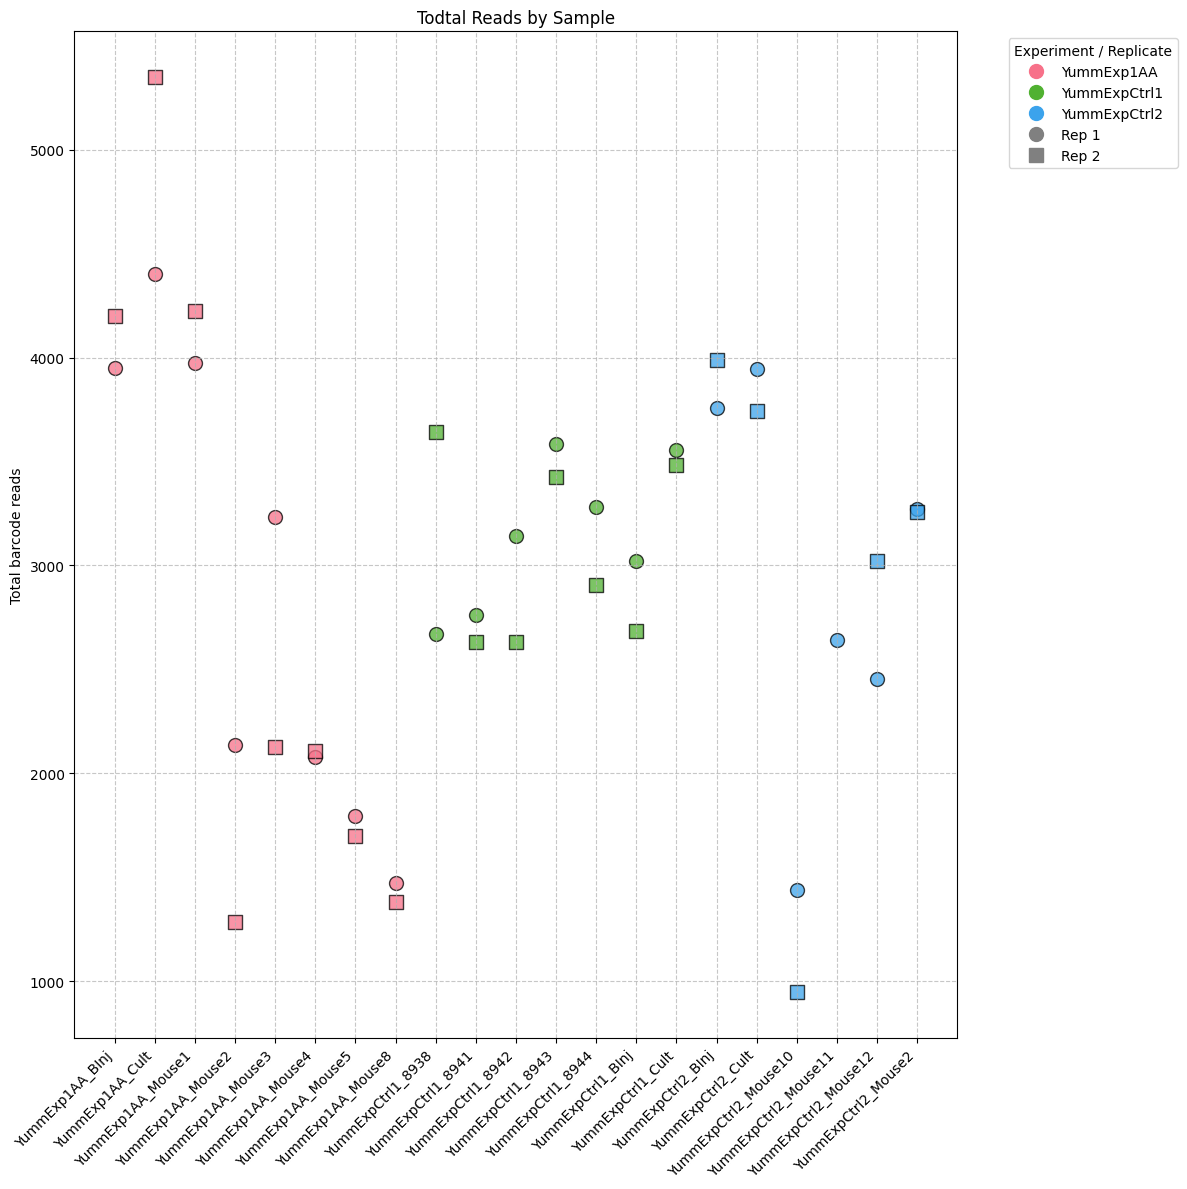

In [70]:
plot_by_sample(data=df_reads, what=None, plot_column=None)

---------------
# Correlación de Pearson

En esta sección se analiza la correlación entre muestras a partir de las lecturas normalizadas por *barcode*. Primero, se reorganizan los datos en formato *wide*, calculando la proporción de *reads* por muestra y normalizándolas respecto al total de cada una. A continuación, se calcula la correlación de Pearson entre todas las muestras y se ordenan jerárquicamente utilizando un *linkage* basado en "1 - correlación" para identificar patrones de similitud. Los resultados se visualizan mediante mapas de calor (*heatmaps*) separados por experimento, donde las filas y columnas corresponden a las muestras y el color indica la fuerza de la correlación, permitiendo comparar de manera intuitiva la similitud entre diferentes condiciones y réplicas.


In [ ]:
# Selección y renombrado de columnas
barcodes_reads = dt.loc[:, ["sample_id", "condition", "cluster_size"]].copy()
barcodes_reads.columns = ["sample", "condition", "reads"]

# Normalizar lecturas por muestra
barcodes_reads["total_reads"] = barcodes_reads.groupby("sample")["reads"].transform("sum")
barcodes_reads["normalized"] = barcodes_reads["reads"] / barcodes_reads["total_reads"]

In [ ]:
# Pivot a formato wide
df = barcodes_reads.pivot_table(index='condition', columns='sample', values='normalized', fill_value=0)

# Calcular correlación Pearson entre samples
corr_df = df.corr(method='pearson')

# Ordenar jerárquicamente
# Creamos el linkage usando "1 - correlation" como distancia
hc_linkage = linkage(1 - corr_df.values, method='average')
order = leaves_list(hc_linkage)
corr_df = corr_df.iloc[order, order]


In [73]:
corr_long = corr_df.reset_index().melt(id_vars='sample', var_name='Var2', value_name='Freq')
corr_long.rename(columns={'sample': 'Var1'}, inplace=True)

# Extraer nombre del experimento (antes del primer "_") 
corr_long['Experiment'] = corr_long['Var1'].apply(lambda x: x.split('_')[0])

# Crear lista de plots por experimento 
unique_experiments = corr_long['Experiment'].unique()
list_tabset = []

In [74]:
# Función para limpiar los nombres de las muestras
def clean_sample_name(name):
    return '_'.join(name.split('_')[1:])  # toma todo después de la primera '_'

# Aplicar limpieza al pivot long
corr_long['Var1_clean'] = corr_long['Var1'].apply(clean_sample_name)
corr_long['Var2_clean'] = corr_long['Var2'].apply(clean_sample_name)

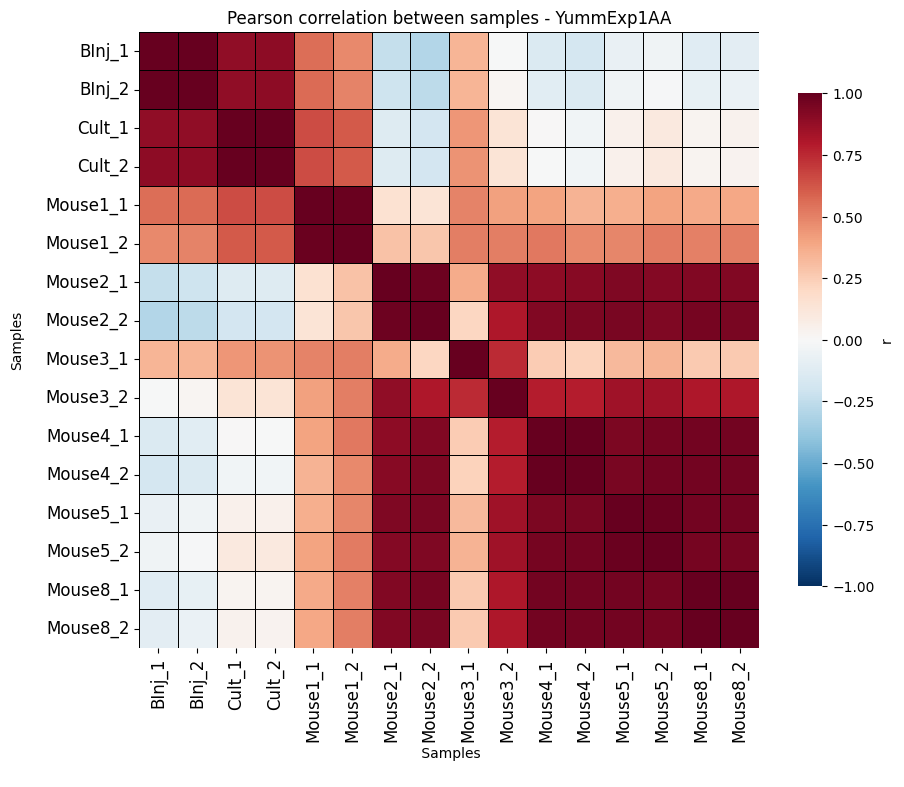

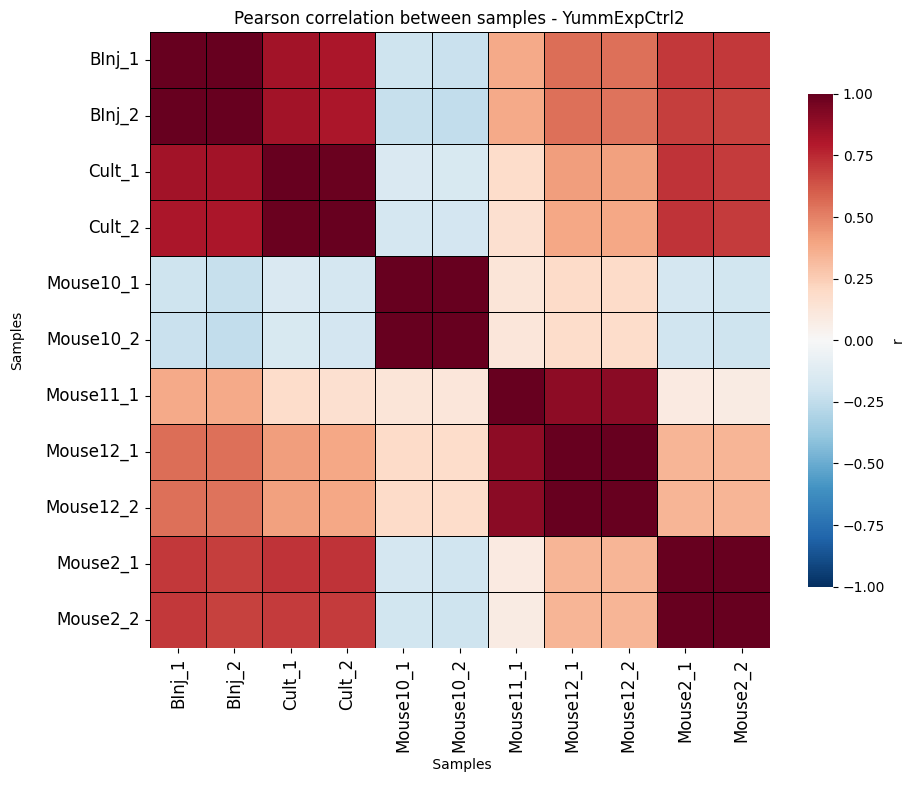

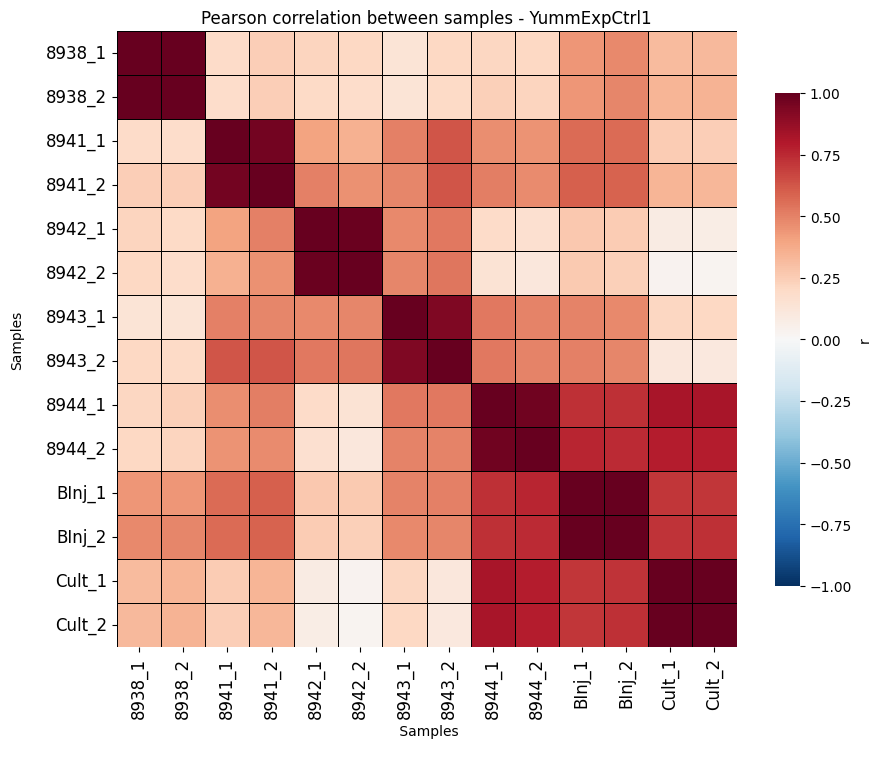

In [75]:
# Convertir a formato long para ggplot-like
for experiment in unique_experiments:
    df1 = corr_long[
        corr_long['Var1'].str.contains(experiment) &
        corr_long['Var2'].str.contains(experiment)
    ]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        df1.pivot(index='Var2_clean', columns='Var1_clean', values='Freq'),
        cmap='RdBu_r',
        center=0,
        vmin=-1, vmax=1,
        linewidths=0.5,
        linecolor='black',
        cbar_kws={'label': 'r', 'shrink': 0.8}
    )
    plt.title(f'Pearson correlation between samples - {experiment}')
    plt.xlabel(' Samples\n')
    plt.ylabel('Samples\n')
    plt.xticks(fontsize=12, color='black')  # ocultar etiquetas X como en R
    plt.yticks(fontsize=12, color='black')
    plt.show()
    
    list_tabset.append(plt)

#Nombres de los tabs (si quieres guardar o etiquetar) 
listnames_tabset = ["Aminoacids", "Control 2", "Control 1"]

---------------
# Experimentos por separado

En esta sección se analiza la relación entre cada *barcode* y la abundancia relativa de las células, evaluada a través de las lecturas normalizadas. Primero, se filtran y procesan los datos del Experimento 1, eliminando valores faltantes y asignando nombres limpios a cada muestra. Se calcula la proporción de *reads* por célula y se normaliza respecto al total de la muestra. A continuación, se generan mapas de calor (*heatmaps*) que muestran la abundancia relativa antes y después de la inyección, así como la relación normalizada de cada *barcode* con respecto a la media antes de la inyección. Finalmente, se calcula el logaritmo en base 2 de esta relación para visualizar mejor incrementos o disminuciones extremas en abundancia, generando un heatmap divergente que facilita la comparación entre condiciones y muestras.


## Experimento medio estándar:

### Control 1:

In [76]:
# Definir el dataframe de samples del experimento 1
samples_exp1 = pd.DataFrame({
    'ID': [
        "YummExpCtrl1_BInj_1", "YummExpCtrl1_BInj_2", 
        "YummExpCtrl1_Cult_1", "YummExpCtrl1_Cult_2", 
        "YummExpCtrl1_8938_1", "YummExpCtrl1_8938_2", 
        "YummExpCtrl1_8941_1", "YummExpCtrl1_8941_2", 
        "YummExpCtrl1_8942_1", "YummExpCtrl1_8942_2", 
        "YummExpCtrl1_8943_1", "YummExpCtrl1_8943_2", 
        "YummExpCtrl1_8944_1", "YummExpCtrl1_8944_2"
    ],
    'sample': [
        "Pool_before_injection_1", "Pool_before_injection_2", 
        "Pool_after_culture_1", "Pool_after_culture_2", 
        "Mouse_8938_1", "Mouse_8938_2", 
        "Mouse_8941_1", "Mouse_8941_2", 
        "Mouse_8942_1", "Mouse_8942_2", 
        "Mouse_8943_1", "Mouse_8943_2", 
        "Mouse_8944_1", "Mouse_8944_2"
    ]
})

### Reads Normalizados

In [ ]:
# Filtrar barcodes_reads para incluir solo samples del experimento 1
bc_ind = barcodes_reads['sample'].isin(samples_exp1['ID'])
bc_reads_exp1 = barcodes_reads[bc_ind].copy()
bc_reads_exp1 = bc_reads_exp1.dropna(subset=['condition'])


# Añadir nombres limpios
clean_ind = bc_reads_exp1['sample'].map(samples_exp1.set_index('ID')['sample'])
bc_reads_exp1['clean_names'] = clean_ind

# Calcular reads por mouse y normalizar
bc_reads_exp1['reads_per_mouse'] = bc_reads_exp1.groupby('sample')['reads'].transform('sum')
bc_reads_exp1['normalized'] = bc_reads_exp1['reads'] / bc_reads_exp1['reads_per_mouse']

# Crear categoría ordenada numéricamente
bc_reads_exp1['category'] = pd.Categorical(
    bc_reads_exp1['condition'],
    categories=sorted(bc_reads_exp1['condition'].unique(), key=lambda x: int(x.replace('barcode', ''))),
    ordered=True
)

C:\Users\Sheimoon\AppData\Local\Temp\ipykernel_15848\3255291430.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = bc_reads_exp1.pivot_table(


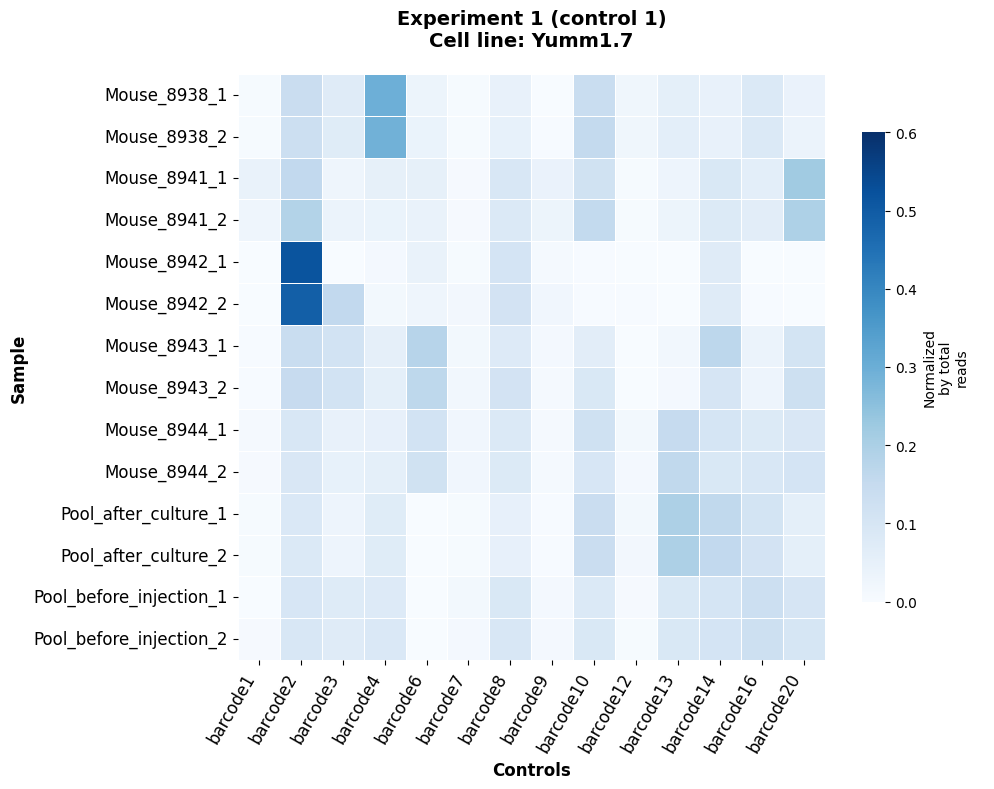

In [78]:
# Crear el heatmap
plt.figure(figsize=(10, 8))

# Crear matriz pivot para el heatmap
heatmap_data = bc_reads_exp1.pivot_table(
    index='clean_names',
    columns='category', 
    values='normalized',
    aggfunc='first'
).fillna(0)

# Crear el heatmap
sns.heatmap(
    heatmap_data,
    cmap='Blues',
    vmin=0,
    vmax=0.6,
    cbar_kws={
        'label': 'Normalized\nby total\nreads\n', 
        'shrink': 0.8
    },
    linewidths=0.5,
    linecolor='white'
)

plt.title('Experiment 1 (control 1)\nCell line: Yumm1.7', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Controls', fontsize=12, fontweight='bold')
plt.ylabel('Sample', fontsize=12, fontweight='bold')

# Rotar las etiquetas del eje x
plt.xticks(rotation=60, ha='right')
plt.yticks(fontsize=12)
plt.tick_params(axis='x', labelsize=12)

plt.tight_layout()
plt.show()

### Normalizar por pool before injection

C:\Users\Sheimoon\AppData\Local\Temp\ipykernel_15848\208474648.py:34: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = bc_reads_exp1_filtered.pivot_table(


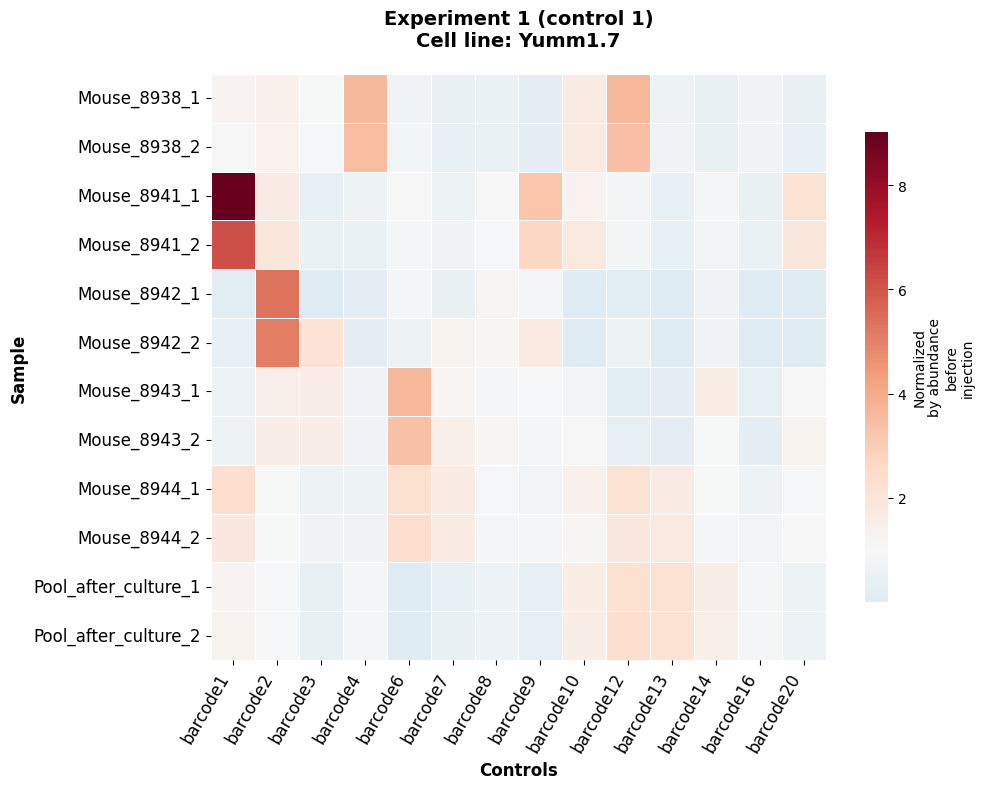

In [79]:
# Calcular el promedio de normalized para las muestras before injection
beforeinjection_exp1 = bc_reads_exp1[
    bc_reads_exp1['clean_names'].isin([
        "Pool_before_injection_1", 
        "Pool_before_injection_2"
    ])
].copy()

beforeinjection_exp1 = beforeinjection_exp1.groupby('condition')['normalized'].mean().reset_index()
beforeinjection_exp1 = beforeinjection_exp1.set_index('condition')

# Filtrar bc_reads_exp1 para excluir las muestras before injection
bc_reads_exp1_filtered = bc_reads_exp1[
    ~bc_reads_exp1['clean_names'].isin([
        "Pool_before_injection_1", 
        "Pool_before_injection_2"
    ])
].copy()

# Añadir la columna bef_inj (promedio before injection por condition)
bc_reads_exp1_filtered['bef_inj'] = bc_reads_exp1_filtered['condition'].map(
    beforeinjection_exp1['normalized']
)

# Calcular normalized by before injection
bc_reads_exp1_filtered['norm_bef_inj'] = (
    bc_reads_exp1_filtered['normalized'] / bc_reads_exp1_filtered['bef_inj']
)

# Crear el heatmap
plt.figure(figsize=(10, 8))

# Crear matriz pivot para el heatmap
heatmap_data = bc_reads_exp1_filtered.pivot_table(
    index='clean_names',
    columns='category', 
    values='norm_bef_inj',
    aggfunc='first'
).fillna(0)

# Crear el heatmap con escala divergente
sns.heatmap(
    heatmap_data,
    cmap='RdBu_r',
    center=1,  # Centro en 1 porque es la relación con before injection
    # vmin=-6, vmax=6,  # Descomenta si quieres límites fijos
    cbar_kws={
        'label': 'Normalized\nby abundance\nbefore\ninjection', 
        'shrink': 0.8
    },
    linewidths=0.5,
    linecolor='white'
)

plt.title('Experiment 1 (control 1)\nCell line: Yumm1.7', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Controls', fontsize=12, fontweight='bold')
plt.ylabel('Sample', fontsize=12, fontweight='bold')

# Rotar las etiquetas del eje x
plt.xticks(rotation=60, ha='right')
plt.yticks(fontsize=12)
plt.tick_params(axis='x', labelsize=12)

plt.tight_layout()
plt.show()

### log2(norm_bef_inj) 

Rango log2: -10.60 a 3.17


C:\Users\Sheimoon\AppData\Local\Temp\ipykernel_15848\1683820101.py:17: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = bc_reads_exp1_filtered.pivot_table(


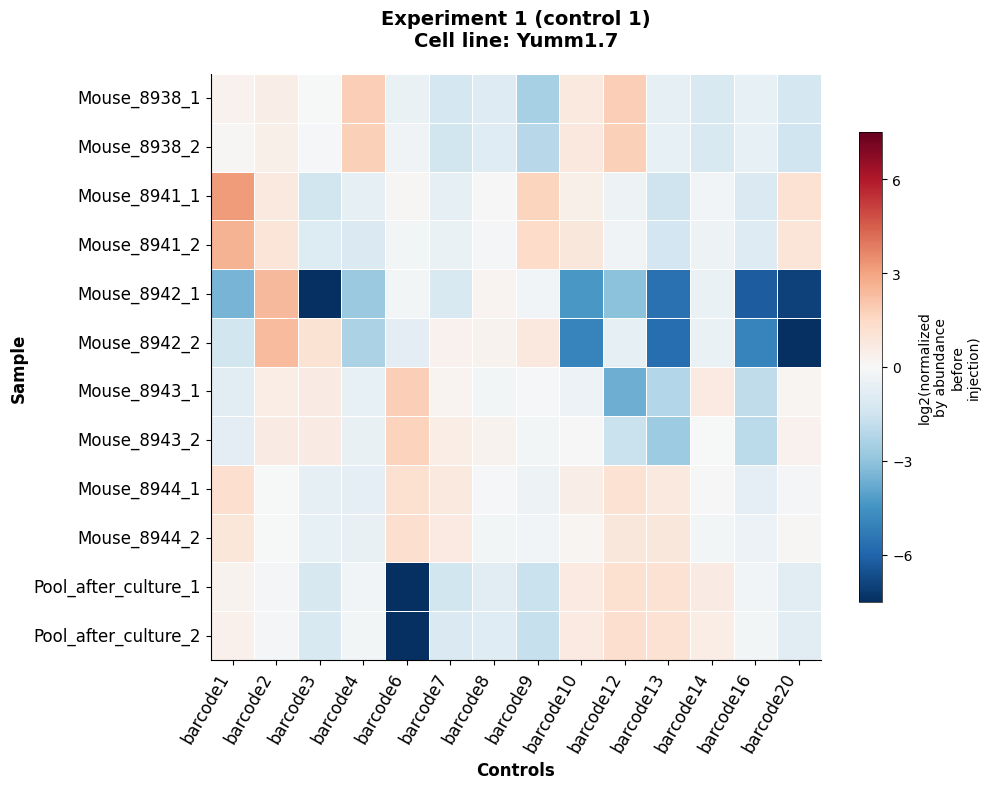

In [80]:
# Calcular log2(norm_bef_inj) - manejar zeros/infinitos
bc_reads_exp1_filtered['log2_norm_bef_inj'] = np.log2(bc_reads_exp1_filtered['norm_bef_inj'])

# Reemplazar infinitos por NaN y luego por el valor máximo/minimo
bc_reads_exp1_filtered['log2_norm_bef_inj'] = bc_reads_exp1_filtered['log2_norm_bef_inj'].replace(
    [np.inf, -np.inf], np.nan
)

# Opcional: establecer límites para valores extremos
log2_values = bc_reads_exp1_filtered['log2_norm_bef_inj'].dropna()
if not log2_values.empty:
    max_val = log2_values.max()
    min_val = log2_values.min()
    print(f"Rango log2: {min_val:.2f} a {max_val:.2f}")

# Crear matriz pivot para el heatmap
heatmap_data = bc_reads_exp1_filtered.pivot_table(
    index='clean_names',
    columns='category', 
    values='log2_norm_bef_inj',
    aggfunc='first'
).fillna(0)

# Crear el heatmap
plt.figure(figsize=(10, 8))

heatmap = sns.heatmap(
    heatmap_data,
    cmap='RdBu_r',
    center=0,  # Centro en 0 para log2
    vmin=-7.5, 
    vmax=7.5,
    cbar_kws={
        'label': 'log2(normalized\nby abundance\nbefore\ninjection)',
        'shrink': 0.8,
        'ticks': [-6, -3, 0, 3, 6]  # Breaks específicos como en R
    },
    linewidths=0.5,
    linecolor='white'
)

# Personalizar la colorbar
cbar = heatmap.collections[0].colorbar
cbar.outline.set_linewidth(0.5)
cbar.outline.set_edgecolor('black')

# Configurar el estilo "classic" similar a theme_classic() de ggplot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)

plt.title('Experiment 1 (control 1)\nCell line: Yumm1.7', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Controls', fontsize=12, fontweight='bold')
plt.ylabel('Sample', fontsize=12, fontweight='bold')

# Rotar las etiquetas del eje x
plt.xticks(rotation=60, ha='right')
plt.yticks(fontsize=12)
plt.tick_params(axis='x', labelsize=12)

plt.tight_layout()
plt.show()

### Control 2:

In [81]:
samples_exp2 = pd.DataFrame({
    'ID': [
        "YummExpCtrl2_Mouse2_1", "YummExpCtrl2_Mouse2_2",
        "YummExpCtrl2_Mouse10_1","YummExpCtrl2_Mouse10_2",
        "YummExpCtrl2_Mouse11_1", "YummExpCtrl2_Mouse12_1", 
        "YummExpCtrl2_Mouse12_2", "YummExpCtrl2_BInj_1", 
        "YummExpCtrl2_BInj_2", "YummExpCtrl2_Cult_1", 
        "YummExpCtrl2_Cult_2"
    ],
    'sample': [
        "Mouse_2_1", "Mouse_2_2", 
        "Mouse_10_1", "Mouse_10_2", 
        "Mouse_11_1", "Mouse_12_1", "Mouse_12_2",
        "Pool_before_injection_1", "Pool_before_injection_2", 
        "Pool_after_culture_1", "Pool_after_culture_2"
    ]
})

In [82]:
# Filtrar barcodes_reads para incluir solo samples del experimento 1
bc_ind = barcodes_reads['sample'].isin(samples_exp2['ID'])
bc_reads_exp2 = barcodes_reads[bc_ind].copy()
bc_reads_exp2 = bc_reads_exp2.dropna(subset=['condition'])


# Añadir nombres limpios
clean_ind = bc_reads_exp2['sample'].map(samples_exp2.set_index('ID')['sample'])
bc_reads_exp2['clean_names'] = clean_ind

# Calcular reads por mouse y normalizar
bc_reads_exp2['reads_per_mouse'] = bc_reads_exp2.groupby('sample')['reads'].transform('sum')
bc_reads_exp2['normalized'] = bc_reads_exp2['reads'] / bc_reads_exp2['reads_per_mouse']

# Crear categoría ordenada numéricamente
bc_reads_exp2['category'] = pd.Categorical(
    bc_reads_exp2['condition'],
    categories=sorted(bc_reads_exp2['condition'].unique(), key=lambda x: int(x.replace('barcode', ''))),
    ordered=True
)


C:\Users\Sheimoon\AppData\Local\Temp\ipykernel_15848\2181572137.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = bc_reads_exp2.pivot_table(


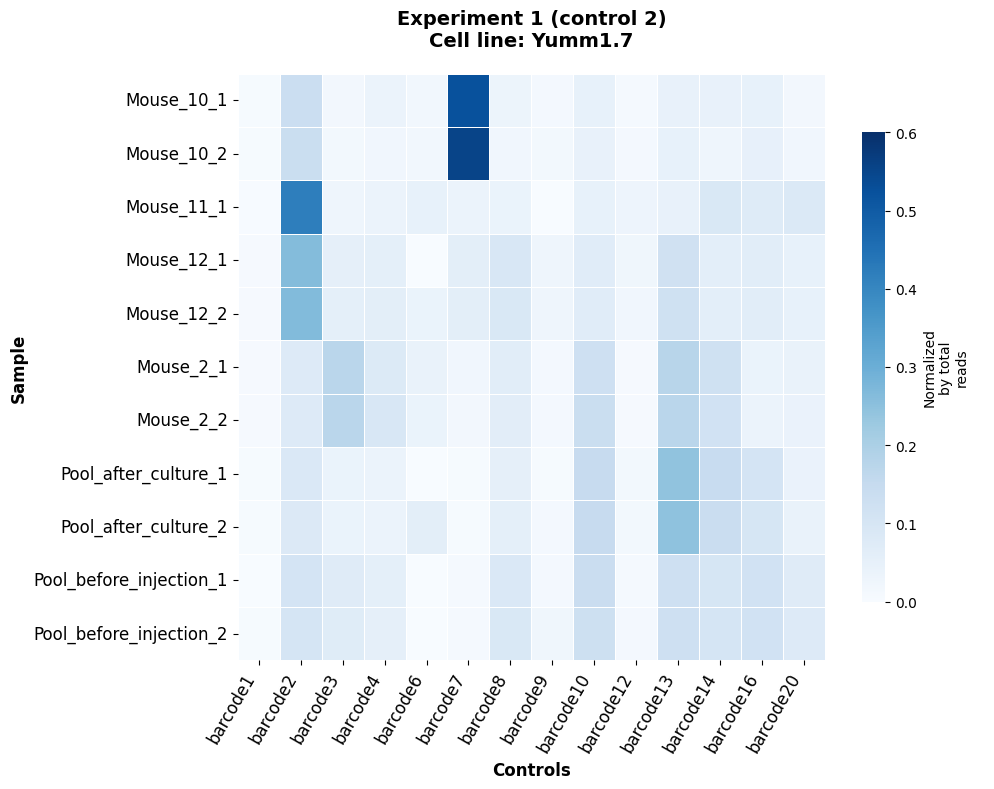

In [83]:
plt.figure(figsize=(10, 8))

heatmap_data = bc_reads_exp2.pivot_table(
    index='clean_names',
    columns='category', 
    values='normalized',
    aggfunc='first'
).fillna(0)

# Crear el heatmap
sns.heatmap(
    heatmap_data,
    cmap='Blues',
    vmin=0,
    vmax=0.6,
    cbar_kws={
        'label': 'Normalized\nby total\nreads\n', 
        'shrink': 0.8
    },
    linewidths=0.5,
    linecolor='white'
)

plt.title('Experiment 1 (control 2)\nCell line: Yumm1.7', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Controls', fontsize=12, fontweight='bold')
plt.ylabel('Sample', fontsize=12, fontweight='bold')

# Rotar las etiquetas del eje x
plt.xticks(rotation=60, ha='right')
plt.yticks(fontsize=12)
plt.tick_params(axis='x', labelsize=12)

plt.tight_layout()
plt.show()

### Pool before inyection

C:\Users\Sheimoon\AppData\Local\Temp\ipykernel_15848\3463507601.py:33: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = bc_reads_exp2_filtered.pivot_table(


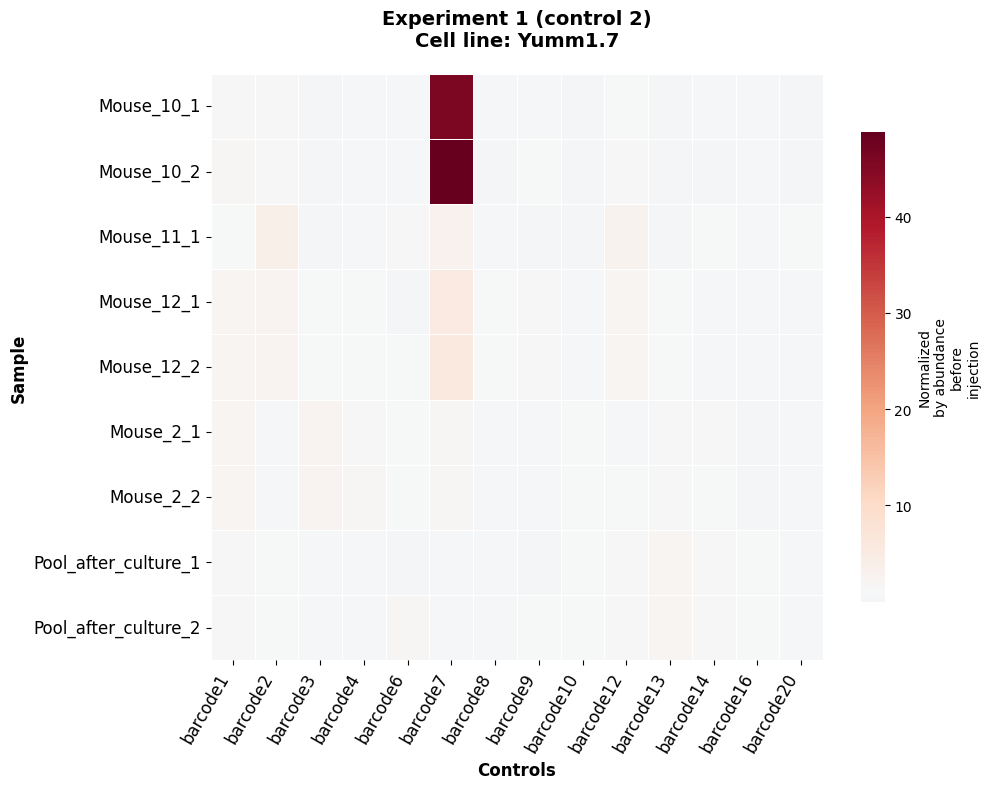

In [84]:
# Calcular el promedio de normalized para las muestras before injection
beforeinjection_exp2 = bc_reads_exp2[
    bc_reads_exp2['clean_names'].isin([
        "Pool_before_injection_1", 
        "Pool_before_injection_2"
    ])
].copy()

beforeinjection_exp2 = beforeinjection_exp2.groupby('condition')['normalized'].mean().reset_index()
beforeinjection_exp2 = beforeinjection_exp2.set_index('condition')

# Filtrar bc_reads_exp1 para excluir las muestras before injection
bc_reads_exp2_filtered = bc_reads_exp2[
    ~bc_reads_exp2['clean_names'].isin([
        "Pool_before_injection_1", 
        "Pool_before_injection_2"
    ])
].copy()

# Añadir la columna bef_inj (promedio before injection por condition)
bc_reads_exp2_filtered['bef_inj'] = bc_reads_exp2_filtered['condition'].map(
    beforeinjection_exp2['normalized']
)

# Calcular normalized by before injection
bc_reads_exp2_filtered['norm_bef_inj'] = (
    bc_reads_exp2_filtered['normalized'] / bc_reads_exp2_filtered['bef_inj']
)

# Crear el heatmap
plt.figure(figsize=(10, 8))

heatmap_data = bc_reads_exp2_filtered.pivot_table(
    index='clean_names',
    columns='category', 
    values='norm_bef_inj',
    aggfunc='first'
).fillna(0)

sns.heatmap(
    heatmap_data,
    cmap='RdBu_r',
    center=1,  # Centro en 1 porque es la relación con before injection
    # vmin=-6, vmax=6,  # Descomenta si quieres límites fijos
    cbar_kws={
        'label': 'Normalized\nby abundance\nbefore\ninjection', 
        'shrink': 0.8
    },
    linewidths=0.5,
    linecolor='white'
)

plt.title('Experiment 1 (control 2)\nCell line: Yumm1.7', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Controls', fontsize=12, fontweight='bold')
plt.ylabel('Sample', fontsize=12, fontweight='bold')

# Rotar las etiquetas del eje x
plt.xticks(rotation=60, ha='right')
plt.yticks(fontsize=12)
plt.tick_params(axis='x', labelsize=12)

plt.tight_layout()
plt.show()

Rango log2: -9.28 a 5.61


C:\Users\Sheimoon\AppData\Local\Temp\ipykernel_15848\2778683142.py:17: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = bc_reads_exp2_filtered.pivot_table(


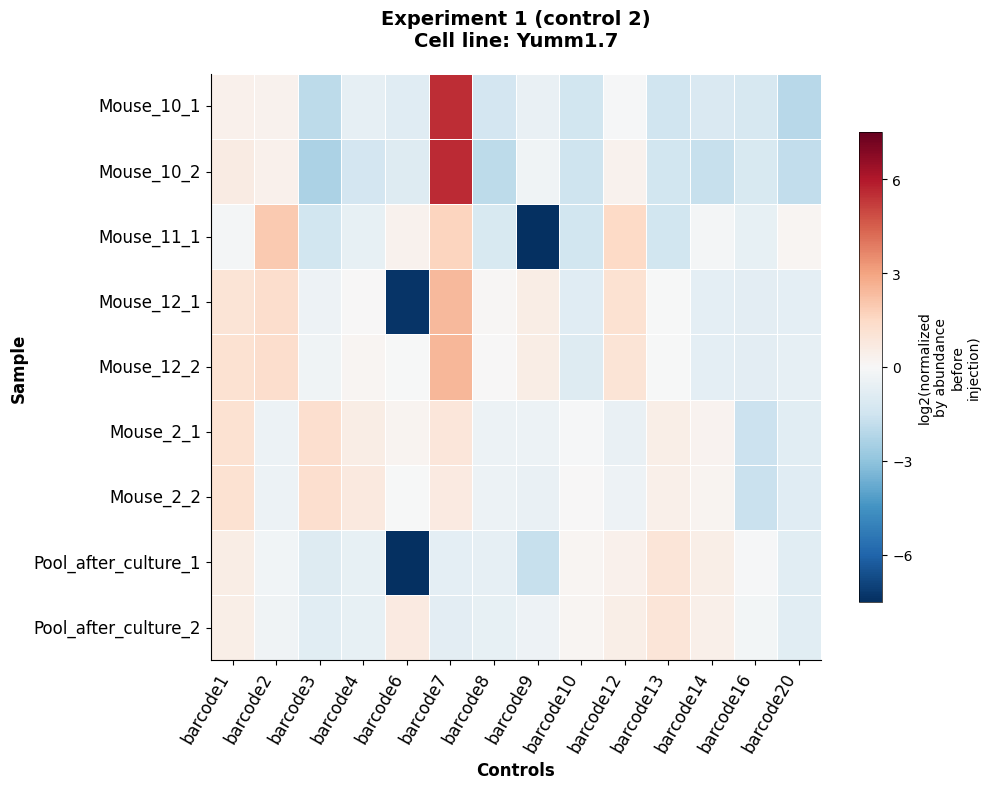

In [85]:
# Calcular log2(norm_bef_inj) - manejar zeros/infinitos
bc_reads_exp2_filtered['log2_norm_bef_inj'] = np.log2(bc_reads_exp2_filtered['norm_bef_inj'])

# Reemplazar infinitos por NaN y luego por el valor máximo/minimo
bc_reads_exp2_filtered['log2_norm_bef_inj'] = bc_reads_exp2_filtered['log2_norm_bef_inj'].replace(
    [np.inf, -np.inf], np.nan
)

# Opcional: establecer límites para valores extremos
log2_values = bc_reads_exp2_filtered['log2_norm_bef_inj'].dropna()
if not log2_values.empty:
    max_val = log2_values.max()
    min_val = log2_values.min()
    print(f"Rango log2: {min_val:.2f} a {max_val:.2f}")

# Crear matriz pivot para el heatmap
heatmap_data = bc_reads_exp2_filtered.pivot_table(
    index='clean_names',
    columns='category', 
    values='log2_norm_bef_inj',
    aggfunc='first'
).fillna(0)

# Crear el heatmap
plt.figure(figsize=(10, 8))

heatmap = sns.heatmap(
    heatmap_data,
    cmap='RdBu_r',
    center=0,  # Centro en 0 para log2
    vmin=-7.5, 
    vmax=7.5,
    cbar_kws={
        'label': 'log2(normalized\nby abundance\nbefore\ninjection)',
        'shrink': 0.8,
        'ticks': [-6, -3, 0, 3, 6]  # Breaks específicos como en R
    },
    linewidths=0.5,
    linecolor='white'
)

# Personalizar la colorbar
cbar = heatmap.collections[0].colorbar
cbar.outline.set_linewidth(0.5)
cbar.outline.set_edgecolor('black')

# Configurar el estilo "classic" similar a theme_classic() de ggplot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)

plt.title('Experiment 1 (control 2)\nCell line: Yumm1.7', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Controls', fontsize=12, fontweight='bold')
plt.ylabel('Sample', fontsize=12, fontweight='bold')

# Rotar las etiquetas del eje x
plt.xticks(rotation=60, ha='right')
plt.yticks(fontsize=12)
plt.tick_params(axis='x', labelsize=12)

plt.tight_layout()
plt.show()

## Experimento 2:

En el Experimento 2 se analiza la relación entre cada *barcode* y la condición de cultivo de las células bajo diferentes tratamientos de aminoácidos. Se preparan los datos filtrando las muestras correspondientes y asignando nombres limpios a cada una. Se calcula la proporción de *reads* normalizada por muestra y se asignan las condiciones específicas a cada *barcode*. A continuación, se generan gráficos de dispersión y mapas de calor que muestran la abundancia relativa de cada *barcode* antes y después de la inyección, así como la relación normalizada con respecto a la media antes de la inyección. Finalmente, se calcula el logaritmo en base 2 de esta relación para visualizar incrementos o disminuciones significativas en abundancia, produciendo un heatmap divergente que facilita la comparación entre condiciones y muestras.


In [86]:
samples_exp1AA = pd.DataFrame({
    'ID': [
        "YummExp1AA_BInj_1", "YummExp1AA_BInj_2",
        "YummExp1AA_Cult_1", "YummExp1AA_Cult_2",
        "YummExp1AA_Mouse1_1", "YummExp1AA_Mouse1_2",
        "YummExp1AA_Mouse2_1", "YummExp1AA_Mouse2_2",
        "YummExp1AA_Mouse3_1", "YummExp1AA_Mouse3_2", 
        "YummExp1AA_Mouse4_1", "YummExp1AA_Mouse4_2", 
        "YummExp1AA_Mouse5_1", "YummExp1AA_Mouse5_2",
        "YummExp1AA_Mouse8_1", "YummExp1AA_Mouse8_2"
    ],
    'sample': [
        "Pool_before_injection_1", "Pool_before_injection_2", 
        "Pool_after_culture_1", "Pool_after_culture_2", 
        "Mouse_1_1", "Mouse_1_2", 
        "Mouse_2_1", "Mouse_2_2", 
        "Mouse_3_1", "Mouse_3_2", 
        "Mouse_4_1", "Mouse_4_2",
        "Mouse_5_1", "Mouse_5_2",
        "Mouse_8_1", "Mouse_8_2"
    ]
})


In [87]:
# Lista de condiciones
aa_condition = [
    "control_1", "no_phe", "plus_phe", "no_thr", "no_trp",
    "plus_trp", "no_met", "plus_met", "no_lys", "no_his",
    "plus_his", "control_2", "plus_thr", "plus_lys"
]

# Lista de barcodes en el mismo orden
condition_barcode = [
    "barcode1", "barcode2", "barcode3", "barcode4", "barcode6",
    "barcode7", "barcode8", "barcode9", "barcode10", "barcode12",
    "barcode13", "barcode14", "barcode16", "barcode20"
]

# Diccionario barcode → condición
barcode_to_condition = dict(zip(condition_barcode, aa_condition))



In [88]:
barcode_to_condition

{'barcode1': 'control_1',
 'barcode2': 'no_phe',
 'barcode3': 'plus_phe',
 'barcode4': 'no_thr',
 'barcode6': 'no_trp',
 'barcode7': 'plus_trp',
 'barcode8': 'no_met',
 'barcode9': 'plus_met',
 'barcode10': 'no_lys',
 'barcode12': 'no_his',
 'barcode13': 'plus_his',
 'barcode14': 'control_2',
 'barcode16': 'plus_thr',
 'barcode20': 'plus_lys'}

In [89]:
# Filtrar barcodes_reads para incluir solo samples del experimento 1
bc_ind = barcodes_reads['sample'].isin(samples_exp1AA['ID'])
bc_reads_exp1AA = barcodes_reads[bc_ind].copy()
bc_reads_exp1AA = bc_reads_exp1AA.dropna(subset=['condition'])


# Añadir nombres limpios
clean_ind = bc_reads_exp1AA['sample'].map(samples_exp1AA.set_index('ID')['sample'])
bc_reads_exp1AA['clean_names'] = clean_ind

# Calcular reads por mouse y normalizar
bc_reads_exp1AA['reads_per_mouse'] = bc_reads_exp1AA.groupby('sample')['reads'].transform('sum')
bc_reads_exp1AA['normalized'] = bc_reads_exp1AA['reads'] / bc_reads_exp1AA['reads_per_mouse']

# Crear categoría ordenada numéricamente
bc_reads_exp1AA['category'] = pd.Categorical(
    bc_reads_exp1AA['condition'],
    categories=sorted(bc_reads_exp2['condition'].unique(), key=lambda x: int(x.replace('barcode', ''))),
    ordered=True
)


In [90]:
# Filtrar
bc_reads_aa = barcodes_reads[barcodes_reads['sample'].isin(samples_exp1AA['ID'])].copy()

# Emparejar nombres limpios
clean_ind = bc_reads_aa['sample'].map(dict(zip(samples_exp1AA['ID'], samples_exp1AA['sample'])))
bc_reads_aa['clean_names'] = clean_ind

# Calcular reads_per_mouse
bc_reads_aa['reads_per_mouse'] = bc_reads_aa.groupby('sample')['reads'].transform('sum')

# Normalizar 
bc_reads_aa['normalized'] = bc_reads_aa['reads'] / bc_reads_aa['reads_per_mouse']

# Asociar condiciones (usando aa_condition y condition_barcode) 
barcode_to_condition = dict(zip(condition_barcode, aa_condition))
bc_reads_aa['category'] = bc_reads_aa['condition'].map(barcode_to_condition)

# Limpiar nombres de barcode
bc_reads_aa['condition'] = bc_reads_aa['condition'].str.replace('barcode', '', regex=False)

C:\Users\Sheimoon\AppData\Local\Temp\ipykernel_15848\1817506088.py:15: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = bc_reads_aa.pivot_table(index='clean_names', columns='category', values='normalized', aggfunc='mean')


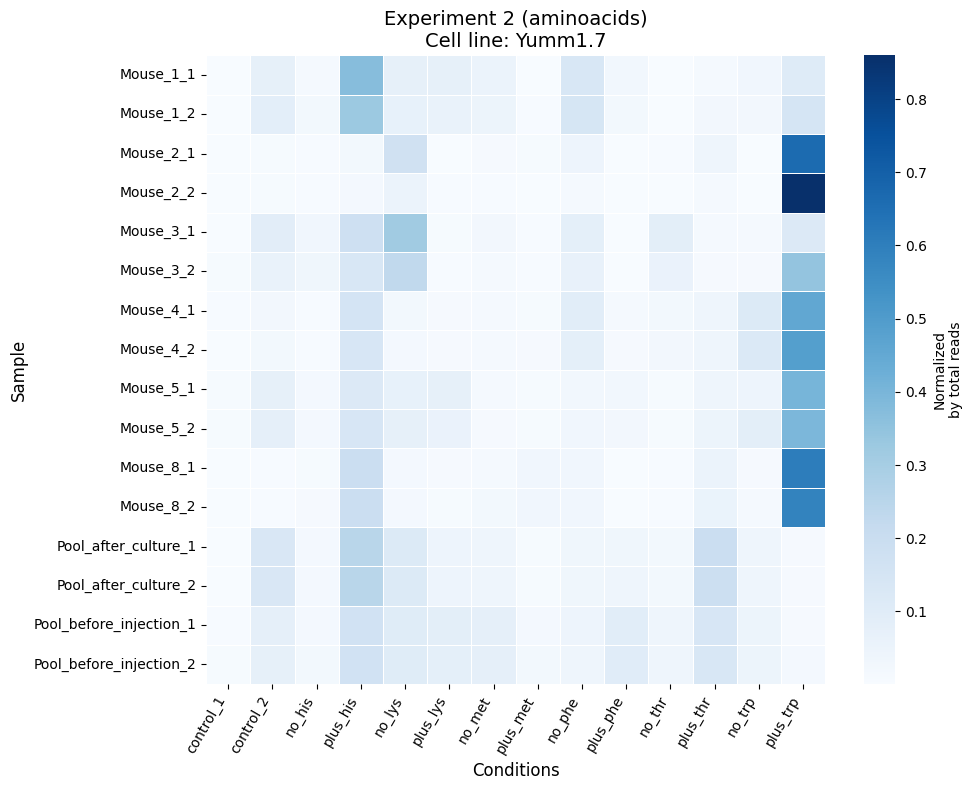

In [92]:

# Ordenar niveles de categoría
condition_order = [
    "control_1", "control_2", 
    "no_his", "plus_his",
    "no_lys", "plus_lys",
    "no_met", "plus_met",
    "no_phe", "plus_phe",
    "no_thr", "plus_thr", 
    "no_trp", "plus_trp"
]
bc_reads_aa['category'] = pd.Categorical(bc_reads_aa['category'], categories=condition_order, ordered=True)

# === 8. Crear el heatmap ===
plt.figure(figsize=(10, 8))
pivot_df = bc_reads_aa.pivot_table(index='clean_names', columns='category', values='normalized', aggfunc='mean')

sns.heatmap(
    pivot_df,
    cmap='Blues',
    linewidths=0.5,
    cbar_kws={'label': 'Normalized\nby total reads'}
)

plt.title("Experiment 2 (aminoacids)\nCell line: Yumm1.7", fontsize=14)
plt.xlabel("Conditions", fontsize=12)
plt.ylabel("Sample", fontsize=12)
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()


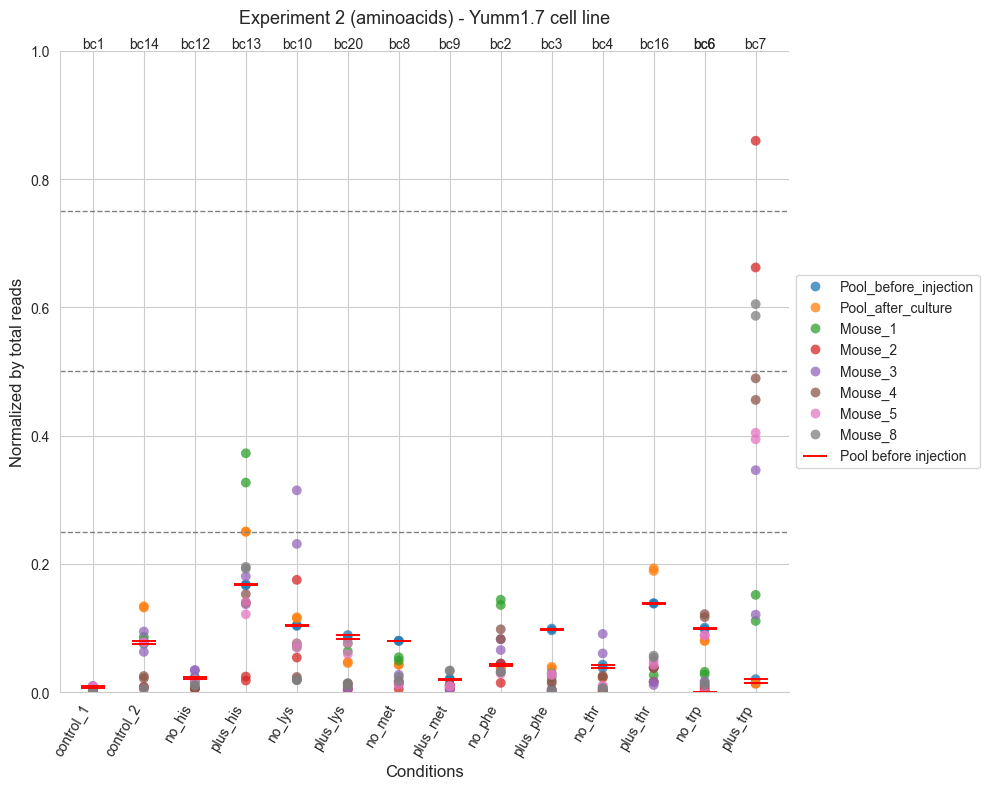

In [93]:
# --- 1. Preparar los datos ---
# Quitar sufijos "_1" o "_2" para agrupar por ratón
bc_reads_aa['color_group'] = bc_reads_aa['clean_names'].str.replace(r'_[12]$', '', regex=True)

# Orden de condiciones
condition_order = [
    "control_1", "control_2", 
    "no_his", "plus_his",
    "no_lys", "plus_lys",
    "no_met", "plus_met",
    "no_phe", "plus_phe",
    "no_thr", "plus_thr", 
    "no_trp", "plus_trp"
]
bc_reads_aa['category'] = pd.Categorical(bc_reads_aa['category'], categories=condition_order, ordered=True)

# --- 2. Crear figura ---
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

# --- 3. Puntos base ---
sns.scatterplot(
    data=bc_reads_aa,
    x='category',
    y='normalized',
    hue='color_group',
    palette='tab10',
    s=50,
    alpha=0.75,
    edgecolor='none'
)

# --- 4. Líneas horizontales (1/4, 2/4, 3/4) ---
for y in [1/4, 2/4, 3/4]:
    plt.axhline(y=y, color='grey', linestyle='--', linewidth=1)

# --- 5. Punto rojo grande para “before injection” ---
mask_before = bc_reads_aa['clean_names'].str.contains('before', case=False, na=False)
sns.scatterplot(
    data=bc_reads_aa[mask_before],
    x='category',
    y='normalized',
    color='red',
    s=300,
    marker='_',
    label='Pool before injection'
)

# --- 6. Etiqueta “bcXX” para el pool específico ---
pool_mask = bc_reads_aa['clean_names'] == 'Pool_before_injection_2'
for _, row in bc_reads_aa[pool_mask].iterrows():
    plt.text(
        x=row['category'],
        y=1.0,
        s=f"bc{row['condition']}",
        ha='center', va='bottom', fontsize=10
    )

# --- 7. Personalización del gráfico ---
plt.title("Experiment 2 (aminoacids) - Yumm1.7 cell line",
          fontsize=13,
          pad = 20)
plt.xlabel("Conditions", fontsize=12)
plt.ylabel("Normalized by total reads", fontsize=12)
plt.xticks(rotation=60, ha='right')
plt.ylim(0, 1)
plt.legend(
    title=None, 
    loc='center left',        # ancla la leyenda al centro izquierdo del área que definimos con bbox_to_anchor
    bbox_to_anchor=(1, 0.5),  # x=1 coloca la leyenda a la derecha del gráfico, y=0.5 la centra verticalmente
    ncol=1                     # número de columnas en la leyenda
)
sns.despine()
plt.tight_layout()
plt.show()


C:\Users\Sheimoon\AppData\Local\Temp\ipykernel_10720\1721348063.py:33: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = bc_reads_exp1aa_filtered.pivot_table(


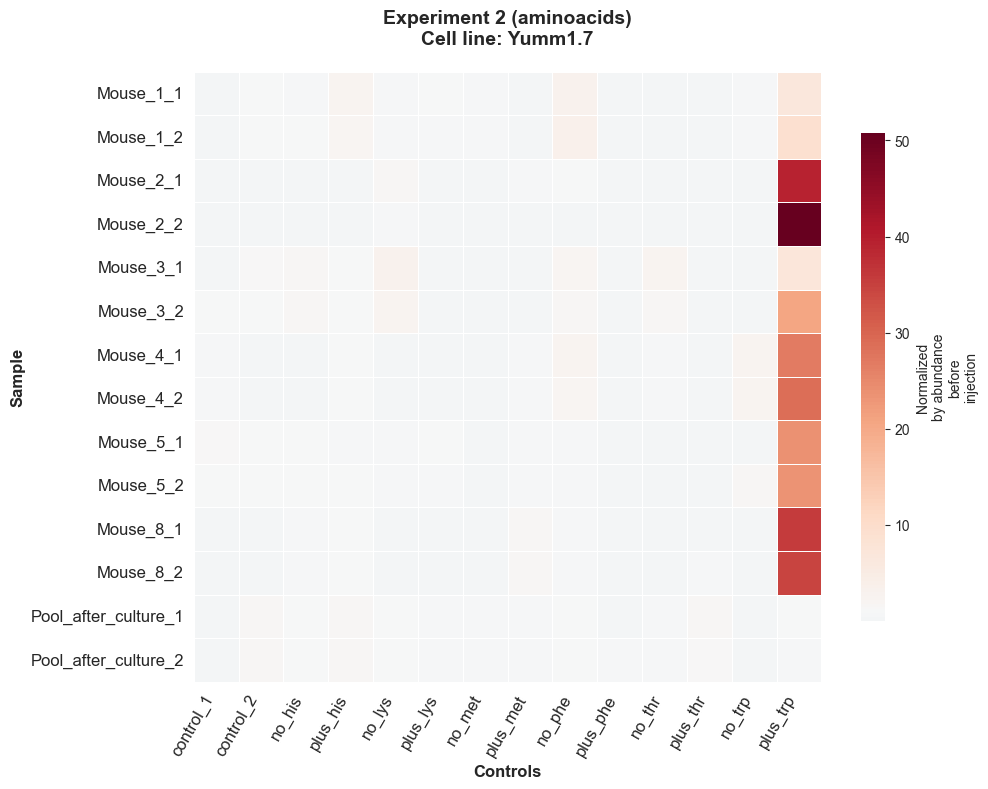

In [88]:
# Calcular el promedio de normalized para las muestras before injection
beforeinjection_exp1aa = bc_reads_aa[
    bc_reads_aa['clean_names'].isin([
        "Pool_before_injection_1", 
        "Pool_before_injection_2"
    ])
].copy()

beforeinjection_exp1aa = beforeinjection_exp1aa.groupby('condition')['normalized'].mean().reset_index()
beforeinjection_exp1aa = beforeinjection_exp1aa.set_index('condition')

# Filtrar bc_reads_exp1 para excluir las muestras before injection
bc_reads_exp1aa_filtered = bc_reads_aa[
    ~bc_reads_aa['clean_names'].isin([
        "Pool_before_injection_1", 
        "Pool_before_injection_2"
    ])
].copy()

# Añadir la columna bef_inj (promedio before injection por condition)
bc_reads_exp1aa_filtered['bef_inj'] = bc_reads_exp1aa_filtered['condition'].map(
    beforeinjection_exp1aa['normalized']
)

# Calcular normalized by before injection
bc_reads_exp1aa_filtered['norm_bef_inj'] = (
    bc_reads_exp1aa_filtered['normalized'] / bc_reads_exp1aa_filtered['bef_inj']
)

# Crear el heatmap
plt.figure(figsize=(10, 8))

heatmap_data = bc_reads_exp1aa_filtered.pivot_table(
    index='clean_names',
    columns='category', 
    values='norm_bef_inj',
    aggfunc='first'
).fillna(0)

sns.heatmap(
    heatmap_data,
    cmap='RdBu_r',
    center=1,  # Centro en 1 porque es la relación con before injection
    # vmin=-6, vmax=6,  # Descomenta si quieres límites fijos
    cbar_kws={
        'label': 'Normalized\nby abundance\nbefore\ninjection', 
        'shrink': 0.8
    },
    linewidths=0.5,
    linecolor='white'
)

plt.title('Experiment 2 (aminoacids)\nCell line: Yumm1.7', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Controls', fontsize=12, fontweight='bold')
plt.ylabel('Sample', fontsize=12, fontweight='bold')

# Rotar las etiquetas del eje x
plt.xticks(rotation=60, ha='right')
plt.yticks(fontsize=12)
plt.tick_params(axis='x', labelsize=12)

plt.tight_layout()
plt.show()

Rango log2: -9.41 a 5.67


C:\Users\Sheimoon\AppData\Local\Temp\ipykernel_10720\69258916.py:17: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = bc_reads_exp1aa_filtered.pivot_table(


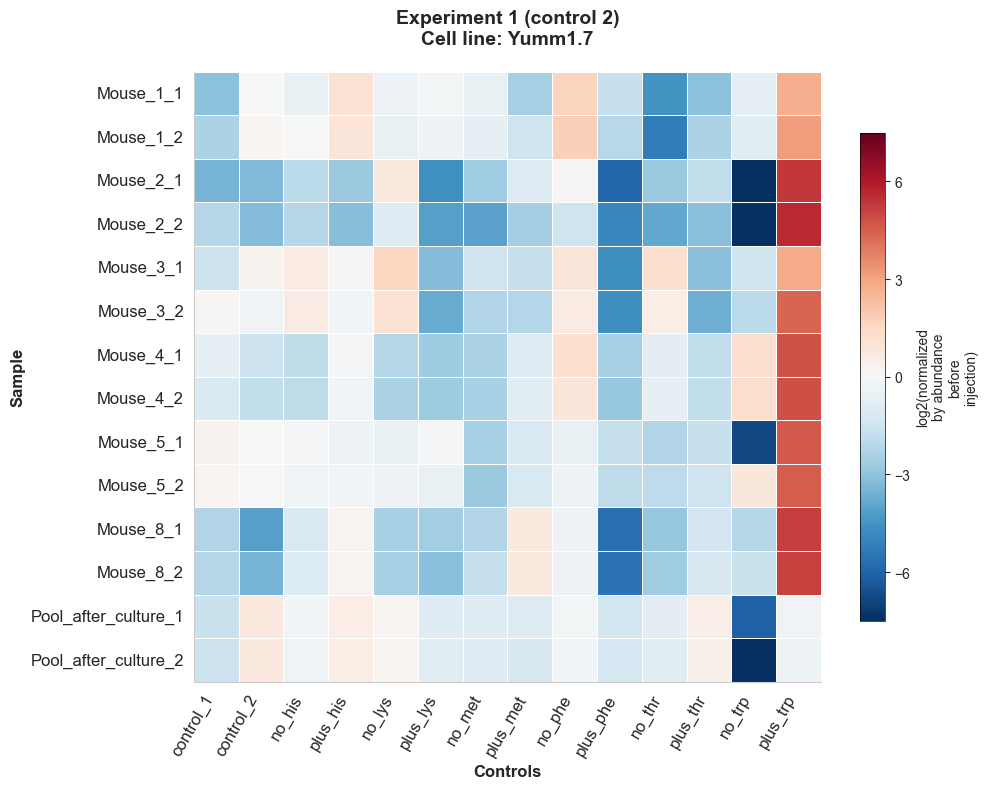

In [89]:
# Calcular log2(norm_bef_inj) - manejar zeros/infinitos
bc_reads_exp1aa_filtered['log2_norm_bef_inj'] = np.log2(bc_reads_exp1aa_filtered['norm_bef_inj'])

# Reemplazar infinitos por NaN y luego por el valor máximo/minimo
bc_reads_exp1aa_filtered['log2_norm_bef_inj'] = bc_reads_exp1aa_filtered['log2_norm_bef_inj'].replace(
    [np.inf, -np.inf], np.nan
)

# Opcional: establecer límites para valores extremos
log2_values = bc_reads_exp1aa_filtered['log2_norm_bef_inj'].dropna()
if not log2_values.empty:
    max_val = log2_values.max()
    min_val = log2_values.min()
    print(f"Rango log2: {min_val:.2f} a {max_val:.2f}")

# Crear matriz pivot para el heatmap
heatmap_data = bc_reads_exp1aa_filtered.pivot_table(
    index='clean_names',
    columns='category', 
    values='log2_norm_bef_inj',
    aggfunc='first'
).fillna(0)

# Crear el heatmap
plt.figure(figsize=(10,8))

heatmap = sns.heatmap(
    heatmap_data,
    cmap='RdBu_r',
    center=0,  # Centro en 0 para log2
    vmin=-7.5, 
    vmax=7.5,
    cbar_kws={
        'label': 'log2(normalized\nby abundance\nbefore\ninjection)',
        'shrink': 0.8,
        'ticks': [-6, -3, 0, 3, 6]  # Breaks específicos como en R
    },
    linewidths=0.5,
    linecolor='white'
)

# Personalizar la colorbar
cbar = heatmap.collections[0].colorbar
cbar.outline.set_linewidth(0.5)
cbar.outline.set_edgecolor('black')

# Configurar el estilo "classic" similar a theme_classic() de ggplot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)

plt.title('Experiment 1 (control 2)\nCell line: Yumm1.7', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Controls', fontsize=12, fontweight='bold')
plt.ylabel('Sample', fontsize=12, fontweight='bold')

# Rotar las etiquetas del eje x
plt.xticks(rotation=60, ha='right')
plt.yticks(fontsize=12)
plt.tick_params(axis='x', labelsize=12)

plt.tight_layout()
plt.show()

-----
# Relación estadística entre condiciones y reads

In [ ]:
# Filtrar grupos
before_df = bc_reads_aa[bc_reads_aa['clean_names'].str.contains('before', case=False)]
after_df  = bc_reads_aa[bc_reads_aa['clean_names'].str.contains('Mouse', case=False)]

results = []

for cond in bc_reads_aa['category'].dropna().unique():
    before_vals = before_df.loc[before_df['category'] == cond, 'normalized']
    after_vals  = after_df.loc[after_df['category'] == cond, 'normalized']
    
    if len(before_vals) > 0 and len(after_vals) > 0:
        # Calcular Log2 Fold Change promedio
        lfc = np.log2((after_vals.mean() + 1e-6) / (before_vals.mean() + 1e-6))
        results.append({'Condition': cond, 'LFC_mean': lfc})

# Crear DataFrame final
lfc_df = pd.DataFrame(results).sort_values('LFC_mean', ascending=False)

lfc_df


,Condition,LFC_mean
3,plus_trp,4.674840
13,no_phe,0.636416
10,plus_his,-0.003770
9,no_lys,-0.119794
0,no_trp,-0.458542
4,no_his,-0.513519
7,control_2,-0.764072
1,plus_met,-0.782266
6,no_thr,-0.998579
2,control_1,-1.034347


In [ ]:
# --- 1. Definir subconjuntos ---
before_df = bc_reads_aa[bc_reads_aa['clean_names'].str.contains('Pool_before', case=False)]
after_cult_df = bc_reads_aa[bc_reads_aa['clean_names'].str.contains('Pool_after', case=False)]
after_inj_df  = bc_reads_aa[bc_reads_aa['clean_names'].str.contains('Mouse', case=False)]

# --- 2. Calcular medias y LFC ---
results = []

for cond in bc_reads_aa['category'].dropna().unique():
    before_vals = before_df.loc[before_df['category'] == cond, 'normalized']
    after_cult_vals = after_cult_df.loc[after_cult_df['category'] == cond, 'normalized']
    after_inj_vals  = after_inj_df.loc[after_inj_df['category'] == cond, 'normalized']

    if len(before_vals) > 0 and len(after_inj_vals) > 0:
        # Calcular medias
        before_mean = before_vals.mean()
        after_cult_mean = after_cult_vals.mean() if len(after_cult_vals) > 0 else np.nan
        after_inj_mean  = after_inj_vals.mean()
        
        # LFCs
        lfc_culture = np.log2((after_cult_mean + 1e-6) / (before_mean + 1e-6)) if not np.isnan(after_cult_mean) else np.nan
        lfc_injection = np.log2((after_inj_mean + 1e-6) / (before_mean + 1e-6))

        results.append({
            'Condition': cond,
            'Pool_before_mean': before_mean,
            'Pool_after_mean': after_cult_mean,
            'Mouse_mean': after_inj_mean,
            'LFC_Pool_before_vs_Pool_after': lfc_culture,
            'LFC_Pool_before_vs_Mouse': lfc_injection
        })

# --- 3. DataFrame final ---
lfc_df = pd.DataFrame(results).sort_values('LFC_Pool_before_vs_Mouse', ascending=False)
lfc_df


,Condition,Pool_before_mean,Pool_after_mean,Mouse_mean,LFC_Pool_before_vs_Pool_after,LFC_Pool_before_vs_Mouse
3,plus_trp,0.016919,0.013231,0.432170,-0.354690,4.674840
13,no_phe,0.042324,0.036422,0.065792,-0.216677,0.636416
10,plus_his,0.167134,0.250138,0.166698,0.581717,-0.003770
9,no_lys,0.103828,0.115783,0.095555,0.157232,-0.119794
0,no_trp,0.049740,0.040273,0.036197,-0.304571,-0.458542
4,no_his,0.022092,0.018363,0.015476,-0.266722,-0.513519
7,control_2,0.077571,0.132792,0.045676,0.775567,-0.764072
1,plus_met,0.020210,0.009377,0.011750,-1.107779,-0.782266
6,no_thr,0.040216,0.022863,0.020127,-0.814712,-0.998579
2,control_1,0.007965,0.002587,0.003888,-1.622144,-1.034347


In [ ]:

# Definir grupos principales
bc_reads_aa['group'] = np.where(bc_reads_aa['clean_names'].str.contains('before', case=False), 'Before',
                        np.where(bc_reads_aa['clean_names'].str.contains('culture', case=False), 'AfterCulture',
                        np.where(bc_reads_aa['clean_names'].str.contains('Mouse', case=False), 'AfterInjection', 'Other')))

results = []
posthoc_all = []

for cond in bc_reads_aa['category'].dropna().unique():
    subset = bc_reads_aa[bc_reads_aa['category'] == cond]
    before_vals  = subset.loc[subset['group'] == 'Before', 'normalized']
    culture_vals = subset.loc[subset['group'] == 'AfterCulture', 'normalized']
    mouse_vals   = subset.loc[subset['group'] == 'AfterInjection', 'normalized']
    
    # Filtrar los grupos que existan
    groups = []
    labels = []
    if len(before_vals) > 0:
        groups.append(before_vals); labels.append('Before')
    if len(culture_vals) > 0:
        groups.append(culture_vals); labels.append('AfterCulture')
    if len(mouse_vals) > 0:
        groups.append(mouse_vals); labels.append('AfterInjection')
    
    if len(groups) >= 2:
        # Test global Kruskal-Wallis
        stat, pval = kruskal(*groups)
        results.append({'Condition': cond, 'KW_pvalue': pval})
        
        # Si significativo, hacer posthoc Dunn
        if pval < 0.1:
            sub = subset[subset['group'].isin(labels)]
            dunn = sp.posthoc_dunn(sub, val_col='normalized', group_col='group', p_adjust='fdr_bh')
            dunn = dunn.reset_index().melt(id_vars='index', var_name='Comparison', value_name='p_adj')
            dunn = dunn.rename(columns={'index': 'Group1'})
            dunn['Condition'] = cond
            posthoc_all.append(dunn)
# Tabla de resultados globales
results_df = pd.DataFrame(results)
results_df['KW_padj'] = sp.posthoc_dunn(bc_reads_aa, val_col='normalized', group_col='group', p_adjust='fdr_bh').mean().mean()  # dummy opcional, se puede omitir

In [ ]:

# Corrección múltiple global (Benjamini-Hochberg)

results_df['KW_padj'] = multipletests(results_df['KW_pvalue'], method='fdr_bh')[1]

# Tabla de posthoc (pares)
posthoc_df = pd.concat(posthoc_all, ignore_index=True) if posthoc_all else pd.DataFrame()

# Mostrar resultados
results_df = results_df.sort_values('KW_pvalue')
results_df

,Condition,KW_pvalue,KW_padj
3,plus_trp,0.013253,0.061847
5,plus_phe,0.013253,0.061847
12,plus_thr,0.013253,0.061847
11,no_met,0.037101,0.129853
7,control_2,0.061281,0.160546
8,plus_lys,0.068806,0.160546
6,no_thr,0.243713,0.370498
10,plus_his,0.276163,0.370498
1,plus_met,0.282322,0.370498
2,control_1,0.282842,0.370498


In [132]:
posthoc_df

,Group1,Comparison,p_adj,Condition
0,AfterCulture,AfterCulture,1.000000,plus_trp
1,AfterInjection,AfterCulture,0.039961,plus_trp
2,Before,AfterCulture,0.674424,plus_trp
3,AfterCulture,AfterInjection,0.039961,plus_trp
4,AfterInjection,AfterInjection,1.000000,plus_trp
5,Before,AfterInjection,0.081331,plus_trp
6,AfterCulture,Before,0.674424,plus_trp
7,AfterInjection,Before,0.081331,plus_trp
8,Before,Before,1.000000,plus_trp
9,AfterCulture,AfterCulture,1.000000,plus_phe
